In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn # to implement neural net
import torch.optim as optim # for optimizer
from torch.autograd import Variable # for stochastic gradient descent 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
movies = pd.read_csv('ml-1m/movies.dat', 
                     sep = '::', 
                     header = None, # no header in the data
                     engine = 'python', # to make sure there is no issues while reading the file
                     encoding = 'latin-1' # to make sure the special characters present in the data are handled properly
                    )
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

In [3]:
# Preparing the training set and test set
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')
# converting dataframe to array as required by pytorch
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [11]:
nb_movies = int(max(max(training_set[:, 1]), max(test_set[:, 1])))
nb_users = int(max(max(training_set[:, 0]), max(test_set[:, 0])))

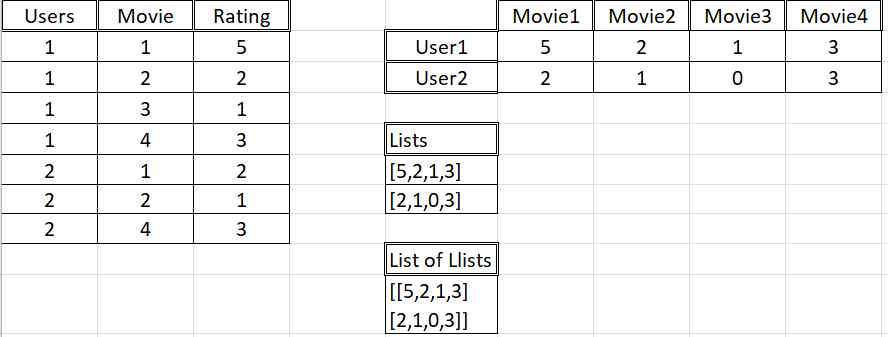

In [5]:
from IPython.display import Image
Image(filename='List_of_lists.PNG')

In [6]:
# The 'Convert_Data' class performs the task as mentioned in the above picture
from convertData import Convert_Data
dp = Convert_Data(training_set, test_set)
training_set, test_set = dp.convert()

In [8]:
from sae import SAE
sae = SAE(nb_movies)
criterion = nn.MSELoss() # criterion to measure the peformance of SAE
optimizer = optim.RMSprop(sae.parameters(), # all the parameters of sae object
                          lr = 0.01, # learning rate(tunable parameter)
                          weight_decay = 0.5# used to reduce the learning rate after every few epochs in order to regulate the convergence
)# optimizer to apply the stochastic gradient descent to update the weiths to reduce the error

In [14]:
# Training the SAE
nb_epoch = 200
# number of iterations
# for loop to pass thru all epocs
for epoch in range(1, nb_epoch + 1):
    train_loss = 0 # loss fuction to measure the peformance
    # comparing the predicted rating with the actual rating we already have in original data
    # using MSE as loss function
    s = 0. # counter to increment after each epoch
    # looping over all users
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0) # a vector that contains all the ratings by a user
        # since pytorch can not accpet 1D vector, we need to unsqueeze. Putting the new dimension in 1st position(index - 0)
        target = input.clone() # copy of a input for later reference as we are going to modify the original input as we move on
        
        # using if condition to optimize the memory by processing only those users whi rated at least one movie
        if torch.sum(target.data > 0) > 0:
            output = sae(input) # vector of predicted rating # calls the forward method from SAE class
            # optimizing the computation
            target.require_grad = False # to make sure the gradient is applied with respect to only the input but not the target
            output[target == 0] = 0 # we want to apply the gradient descent only to non-zero values. Hence directly setting 0s to 0
            loss = criterion(output, target) # loss between actual rating and predicted rating
            # target is the actual rating and output is predicted rating
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10) 
            # mean_corrector: average of the error by only considering the actually rated movies(movies with non-zero ratings)
            # number of movies with non-zero ratings. 1e-10 is added to makes ure demominator is non-zero even when 
            # the first term(total movie rating) is zero
            loss.backward() # function that updates weights on the back-propagation
            train_loss += np.sqrt(loss.data[0] * mean_corrector) # updating RMSE with adjusted mean
            s += 1. # incrementing the counter
            optimizer.step() # applying the optimizer
            # loss.backward() defines the direction of weights(wj=hether to increase or decrease)
            # ptimizer.step() defines the indensity of wights
            
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s)) # average loss(total loss/ number of iterations)

epoch: 1 loss: 0.0260629831671
epoch: 2 loss: 0.0240455547571
epoch: 3 loss: 0.0260670665911
epoch: 4 loss: 0.0240447212363
epoch: 5 loss: 0.0260570055164
epoch: 6 loss: 0.0240417882227
epoch: 7 loss: 0.0260470040752
epoch: 8 loss: 0.0240432682288
epoch: 9 loss: 0.0260497450372
epoch: 10 loss: 0.024043575133
epoch: 11 loss: 0.0260585812994
epoch: 12 loss: 0.0240363594484
epoch: 13 loss: 0.0260594652658
epoch: 14 loss: 0.0240286817519
epoch: 15 loss: 0.0260518877374
epoch: 16 loss: 0.0240315791897
epoch: 17 loss: 0.0260475346379
epoch: 18 loss: 0.0240403312598
epoch: 19 loss: 0.0260505160542
epoch: 20 loss: 0.0240409941257
epoch: 21 loss: 0.0260532400793
epoch: 22 loss: 0.0240311181747
epoch: 23 loss: 0.0260510938958
epoch: 24 loss: 0.0240234565489
epoch: 25 loss: 0.0260482655511
epoch: 26 loss: 0.0240267271855
epoch: 27 loss: 0.0260484065383
epoch: 28 loss: 0.0240329015596
epoch: 29 loss: 0.0260484906291
epoch: 30 loss: 0.0240310001494
epoch: 31 loss: 0.0260455361408
epoch: 32 loss: 0.

In [15]:
# Testing the SAE
test_loss = 0
s = 0.
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0) # making prediction for each user 1 by 1
    # training set is the input that will be used to activate the hidden neurons to get the output 
    # input is all the ratings by this particular user for all the movies he/she has watched
    target = Variable(test_set[id_user]) # real rating provided by a user for a movie
    # predicting the rating for the user for a particular movie. i.e test_set
    if torch.sum(target.data > 0) > 0:
        output = sae(input)
        target.require_grad = False
        output[target == 0] = 0
        loss = criterion(output, target)
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data[0] * mean_corrector)
        s += 1.
print('test loss: ' + str(test_loss/s))

test loss: 0.161192374017


In [16]:
# Predicting the rating for a user for a movie

target_user_id = 3
target_movie_id = 327
input = Variable(training_set[target_user_id - 1]).unsqueeze(0)
output = sae(input)
output_numpy = output.data.numpy()
print (''+ str(output_numpy[0, target_movie_id - 1]))

5.05438
